In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
#load all-unit table; we will append recalculated metrics to this.
all_units=pd.read_parquet(npc_lims.get_cache_path('units',version='0.0.260'))

In [7]:
# session_info=npc_lims.get_session_info('713655_2024-08-09')
# session=DynamicRoutingSession(session_info)
# epochs=pd.read_parquet(npc_lims.get_cache_path('epochs','713655_2024-08-09',version='0.0.260'))

In [8]:
# epochs.query('script_name=="DynamicRouting1"')

# epochs.query('script_name=="Spontaneous"')

In [86]:
# epochs

,start_time,stop_time,script_name,notes,interval_names,tags,session_idx,date,subject_id,session_id
id,,,,,,,,,,
0,76.071655,936.194570,RFMapping,,"[vis_rf_mapping_trials, aud_rf_mapping_trials]",[mapping],0,2023-08-29,668755,668755_2023-08-29_0
1,953.202490,1181.249465,OptoTagging,,[optotagging_trials],[optotagging_control],0,2023-08-29,668755,668755_2023-08-29_0
2,1195.722470,1798.647407,Spontaneous,,[spontaneous_trials],[spontaneous],0,2023-08-29,668755,668755_2023-08-29_0
3,1821.814030,2422.353618,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2023-08-29,668755,668755_2023-08-29_0
4,2438.100281,6084.310180,DynamicRouting1,,"[trials, performance]","[task, rewards]",0,2023-08-29,668755,668755_2023-08-29_0
5,6101.284820,6701.757678,SpontaneousRewards,,[spontaneous_rewards_trials],"[rewards, spontaneous]",0,2023-08-29,668755,668755_2023-08-29_0
6,6718.436420,6948.583837,OptoTagging,,[optotagging_trials],[optotagging_control],0,2023-08-29,668755,668755_2023-08-29_0


In [24]:
#define functions to compute metrics

import spikeinterface.qualitymetrics.misc_metrics as metrics
import math

def calculate_isi_violations_ratio(spike_times,total_duration_s,isi_threshold_ms=1.5, min_isi_ms=0):

    isi_threshold_s = isi_threshold_ms / 1000
    min_isi_s = min_isi_ms / 1000
    spike_train_list=[spike_times]

    ratio, _, count = metrics.isi_violations(spike_train_list, total_duration_s, isi_threshold_s, min_isi_s)

    return ratio

def calculate_presence_ratio(spike_samples, total_duration_s, bin_duration_s=60.0, mean_fr_ratio_thresh=0.0):

    total_length = int(total_duration_s * 30000)
    bin_duration_samples = int((bin_duration_s * 30000))
    num_bin_edges = total_length // bin_duration_samples + 1
    bin_edges = np.arange(num_bin_edges) * bin_duration_samples
    unit_fr = len(spike_samples) / total_duration_s

    bin_n_spikes_thres = math.floor(unit_fr * bin_duration_s * mean_fr_ratio_thresh)

    presence_ratio = metrics.presence_ratio(spike_samples, total_length,bin_edges=bin_edges,bin_n_spikes_thres=bin_n_spikes_thres,)

    return presence_ratio

In [104]:
ephys_sessions=all_units['session_id'].unique()

new_unit_metrics=all_units['unit_id']
new_unit_metrics['isi_violations_ratio_task']=np.nan
new_unit_metrics['presence_ratio_task']=np.nan
new_unit_metrics['sliding_rp_violation_task']=np.nan

new_unit_metrics['isi_violations_ratio_spont']=np.nan
new_unit_metrics['presence_ratio_spont']=np.nan
new_unit_metrics['sliding_rp_violation_spont']=np.nan

new_unit_metrics['isi_violations_ratio_normal']=np.nan
new_unit_metrics['presence_ratio_normal']=np.nan
new_unit_metrics['sliding_rp_violation_normal']=np.nan

start_time=time.time()

temp_new_unit_metrics={
    'unit_id':[],
    'isi_violations_ratio_task':[],
    'presence_ratio_task':[],
    'sliding_rp_violation_task':[],
    'isi_violations_ratio_spont':[],
    'presence_ratio_spont':[],
    'sliding_rp_violation_spont':[],
    'isi_violations_ratio_normal':[],
    'presence_ratio_normal':[],
    'sliding_rp_violation_normal':[],
}

for ss in ephys_sessions[:]:
        print('loading session '+ss)
        print('time elapsed: '+str(np.round(time.time()-start_time,decimals=2))+' seconds')

        has_spont_epoch=False
    # try:
        # session=DynamicRoutingSession(ss)
        session_info=npc_lims.get_session_info(ss)
        units=data_utils.load_trials_or_units(session_info,'units')
    # except:
    #     print('loading data failed for session '+ss+'; skipping')
    #     continue

    # try:
        #get task timing
        epochs=pd.read_parquet(npc_lims.get_cache_path('epochs',ss,version='0.0.260'))
        
        task_epoch=epochs.query('script_name=="DynamicRouting1"')
        if len(task_epoch)==1:
            task_start_time=task_epoch['start_time'].values[0]
            task_stop_time=task_epoch['stop_time'].values[0]
        else:
            print('no task epoch found for session '+ss+'; skipping')
            continue

        spont_epochs=epochs.query('script_name=="Spontaneous"')
        if len(spont_epochs)>0:
            spont_epoch=spont_epochs.iloc[0]
            has_spont_epoch=True
            spont_start_time=spont_epoch['start_time']
            spont_stop_time=spont_epoch['stop_time']

        for uu,unit in units.iterrows():
            spike_times=unit['spike_times']

            #full experiment
            full_spike_times=spike_times
            full_spike_times=full_spike_times-full_spike_times[0]
            full_spike_samples=[np.round(full_spike_times*30000).astype(int)]
            if len(full_spike_times)<100:
                full_sliding_rp=np.nan
                full_isi_violations_ratio=np.nan
                full_presence_ratio=np.nan
            else:
                sample_rate=30000
                full_duration=np.max(full_spike_times)-np.min(full_spike_times)

                full_sliding_rp=metrics.slidingRP_violations(
                    full_spike_samples,
                    sample_rate,
                    full_duration,
                    bin_size_ms=0.25,
                    window_size_s=1,
                    exclude_ref_period_below_ms=0.5,
                    max_ref_period_ms=10,
                    contamination_values=None,
                    return_conf_matrix=False,
                )
                full_isi_violations_ratio = calculate_isi_violations_ratio(full_spike_times,full_duration)
                full_presence_ratio = calculate_presence_ratio(full_spike_samples, full_duration)

            #task only
            task_spike_times=spike_times[(spike_times>=task_start_time) & (spike_times<=task_stop_time)]
            task_spike_times=task_spike_times-task_start_time
            task_spike_samples=[np.round(task_spike_times*30000).astype(int)]

            if len(task_spike_times)<100:
                task_sliding_rp=np.nan
                task_isi_violations_ratio=np.nan
                task_presence_ratio=np.nan

            else:
                sample_rate=30000
                task_duration=task_stop_time-task_start_time
                
                task_sliding_rp=metrics.slidingRP_violations(
                    task_spike_samples,
                    sample_rate,
                    task_duration,
                    bin_size_ms=0.25,
                    window_size_s=1,
                    exclude_ref_period_below_ms=0.5,
                    max_ref_period_ms=10,
                    contamination_values=None,
                    return_conf_matrix=False,
                )
                
                task_isi_violations_ratio = calculate_isi_violations_ratio(task_spike_times,task_duration)
                task_presence_ratio = calculate_presence_ratio(task_spike_samples, task_duration)

            if has_spont_epoch:
                spont_spike_times=spike_times[(spike_times>=spont_start_time) & (spike_times<=spont_stop_time)]
                spont_spike_times=spont_spike_times-spont_start_time
                spont_spike_samples=[np.round(spont_spike_times*30000).astype(int)]

                if len(spont_spike_times)<100:
                    spont_sliding_rp=np.nan
                    spont_isi_violations_ratio=np.nan
                    spont_presence_ratio=np.nan

                else:
                    spont_duration=spont_stop_time-spont_start_time
                    
                    spont_sliding_rp=metrics.slidingRP_violations(
                        spont_spike_samples,
                        sample_rate,
                        spont_duration,
                        bin_size_ms=0.25,
                        window_size_s=1,
                        exclude_ref_period_below_ms=0.5,
                        max_ref_period_ms=10,
                        contamination_values=None,
                        return_conf_matrix=False,
                    )

                    spont_isi_violations_ratio = calculate_isi_violations_ratio(spont_spike_times,spont_duration)
                    spont_presence_ratio = calculate_presence_ratio(spont_spike_samples, spont_duration)

            else:
                spont_sliding_rp=np.nan
                spont_isi_violations_ratio=np.nan
                spont_presence_ratio=np.nan
            
            temp_new_unit_metrics['unit_id'].append(unit['unit_id'])
            temp_new_unit_metrics['isi_violations_ratio_task'].append(task_isi_violations_ratio)
            temp_new_unit_metrics['presence_ratio_task'].append(task_presence_ratio)
            temp_new_unit_metrics['sliding_rp_violation_task'].append(task_sliding_rp)
            temp_new_unit_metrics['isi_violations_ratio_spont'].append(spont_isi_violations_ratio)
            temp_new_unit_metrics['presence_ratio_spont'].append(spont_presence_ratio)
            temp_new_unit_metrics['sliding_rp_violation_spont'].append(spont_sliding_rp)
            temp_new_unit_metrics['isi_violations_ratio_normal'].append(full_isi_violations_ratio)
            temp_new_unit_metrics['presence_ratio_normal'].append(full_presence_ratio)
            temp_new_unit_metrics['sliding_rp_violation_normal'].append(full_sliding_rp)

    # except:
    #     print('metrics computation failed for session '+ss+'; skipping')
        



C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_26020\2825179675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_unit_metrics['isi_violations_ratio_task']=np.nan


loading session 620263_2022-07-26_0
time elapsed: 0.0 seconds
620263_2022-07-26 cached units loaded
loading session 620263_2022-07-27_0
time elapsed: 58.87 seconds
620263_2022-07-27 cached units loaded
loading session 620264_2022-08-02_0
time elapsed: 104.17 seconds
620264_2022-08-02 cached units loaded
loading session 626791_2022-08-15_0
time elapsed: 172.47 seconds
626791_2022-08-15 cached units loaded
loading session 626791_2022-08-16_0
time elapsed: 273.87 seconds
626791_2022-08-16 cached units loaded
loading session 626791_2022-08-17_0
time elapsed: 309.34 seconds
626791_2022-08-17 cached units loaded
loading session 628801_2022-09-19_0
time elapsed: 396.62 seconds
628801_2022-09-19 cached units loaded
loading session 628801_2022-09-20_0
time elapsed: 507.33 seconds
628801_2022-09-20 cached units loaded
loading session 636397_2022-09-26_0
time elapsed: 541.86 seconds
636397_2022-09-26 cached units loaded
loading session 636397_2022-09-27_0
time elapsed: 612.47 seconds
636397_2022-

In [95]:
temp_new_unit_metrics_df=pd.DataFrame(temp_new_unit_metrics)

temp_new_unit_metrics_df

,unit_id,isi_violations_ratio_task,presence_ratio_task,sliding_rp_violation_task,isi_violations_ratio_spont,presence_ratio_spont,sliding_rp_violation_spont,isi_violations_ratio_normal,presence_ratio_normal,sliding_rp_violation_normal
0,668755_2023-08-29_B-45,0.004267,1.000000,0.01,0.000000,1.0,0.005,0.020966,1.000000,0.015
1,668755_2023-08-29_E-483,0.000000,1.000000,0.19,0.000000,1.0,NaN,0.000000,1.000000,0.145
2,668755_2023-08-29_E-474,0.000000,0.633333,NaN,0.000000,1.0,0.020,0.018334,0.784483,0.020
3,668755_2023-08-29_E-470,0.337301,1.000000,0.19,0.117211,1.0,0.085,0.340144,1.000000,0.220
4,668755_2023-08-29_E-469,0.000000,0.783333,NaN,NaN,NaN,NaN,0.000000,0.755102,NaN
...,...,...,...,...,...,...,...,...,...,...
2823,668755_2023-08-29_D-116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2824,668755_2023-08-29_E-552,NaN,NaN,NaN,NaN,NaN,NaN,17.885489,0.324561,NaN
2825,668755_2023-08-29_E-551,NaN,NaN,NaN,NaN,NaN,NaN,1219.533062,0.221239,NaN
2826,668755_2023-08-29_D-445,44.452443,0.983333,NaN,422.698411,0.8,NaN,72.539060,0.939655,NaN


In [64]:
# task_epoch['start_time']
# ephys_sessions[31]
# spont_epochs


,start_time,stop_time,script_name,notes,interval_names,tags,session_idx,date,subject_id,session_id
id,,,,,,,,,,
2,1172.784608,1775.873118,Spontaneous,,[spontaneous_trials],[spontaneous],0,2024-04-16,703880,703880_2024-04-16_0
6,6666.400210,7269.374804,Spontaneous,,[spontaneous_trials],[spontaneous],0,2024-04-16,703880,703880_2024-04-16_0


In [105]:
savepath=r'D:\recalc_metrics\recalc_metrics.pkl'

temp_new_unit_metrics_df=pd.DataFrame(temp_new_unit_metrics)

temp_new_unit_metrics_df.to_pickle(savepath)


In [109]:
temp_new_unit_metrics_df.columns

Index(['unit_id', 'isi_violations_ratio_task', 'presence_ratio_task',
       'sliding_rp_violation_task', 'isi_violations_ratio_spont',
       'presence_ratio_spont', 'sliding_rp_violation_spont',
       'isi_violations_ratio_normal', 'presence_ratio_normal',
       'sliding_rp_violation_normal'],
      dtype='object')

In [110]:
#merge new metrics with all_units
all_units_new_metrics=all_units.merge(temp_new_unit_metrics_df,on='unit_id',how='left')

In [112]:
len(all_units)

432692

In [162]:
all_units_new_metrics.to_csv(r'D:\recalc_metrics\units_with_recalc_metrics.csv')

In [163]:
all_units_new_metrics

,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,...,session_id,isi_violations_ratio_task,presence_ratio_task,sliding_rp_violation_task,isi_violations_ratio_spont,presence_ratio_spont,sliding_rp_violation_spont,isi_violations_ratio_normal,presence_ratio_normal,sliding_rp_violation_normal
0,0.001179,0.111233,0.134962,276.120000,NaN,NaN,NaN,3.2,1.028898,0.166824,...,620263_2022-07-26_0,0.163927,1.000000,0.240,NaN,NaN,NaN,0.165782,1.000000,0.245
1,0.000162,NaN,NaN,67.860000,NaN,NaN,NaN,9.0,1.362945,0.000000,...,620263_2022-07-26_0,0.000000,0.666667,0.055,NaN,NaN,NaN,0.000000,0.704918,0.050
2,0.000034,NaN,NaN,88.920000,24.320618,3.329016,6.408309,11.0,5.908478,0.149236,...,620263_2022-07-26_0,0.159373,1.000000,0.095,NaN,NaN,NaN,0.163788,1.000000,0.095
3,0.000424,0.266651,0.268533,116.999990,NaN,NaN,NaN,5.8,1.826002,0.079449,...,620263_2022-07-26_0,0.053583,1.000000,0.100,NaN,NaN,NaN,0.079352,1.000000,0.120
4,NaN,NaN,NaN,116.999990,NaN,NaN,NaN,0.2,0.053511,0.000000,...,620263_2022-07-26_0,0.000000,0.816667,NaN,NaN,NaN,NaN,0.000000,0.786885,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432687,NaN,NaN,NaN,191.879990,NaN,NaN,NaN,0.4,0.085364,0.000000,...,761584_2024-10-30_0,0.000000,0.966667,NaN,NaN,NaN,NaN,0.000000,0.951613,NaN
432688,NaN,NaN,NaN,136.890000,NaN,NaN,NaN,0.2,0.044816,0.000000,...,761584_2024-10-30_0,0.000000,0.800000,NaN,NaN,NaN,NaN,0.000000,0.783333,NaN
432689,NaN,NaN,NaN,145.080000,NaN,NaN,NaN,0.6,0.128045,0.000000,...,761584_2024-10-30_0,0.000000,0.983333,NaN,NaN,NaN,NaN,0.000000,0.967213,NaN
432690,0.001308,0.474581,0.216535,124.020000,NaN,NaN,NaN,0.6,0.187800,0.000000,...,761584_2024-10-30_0,0.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN


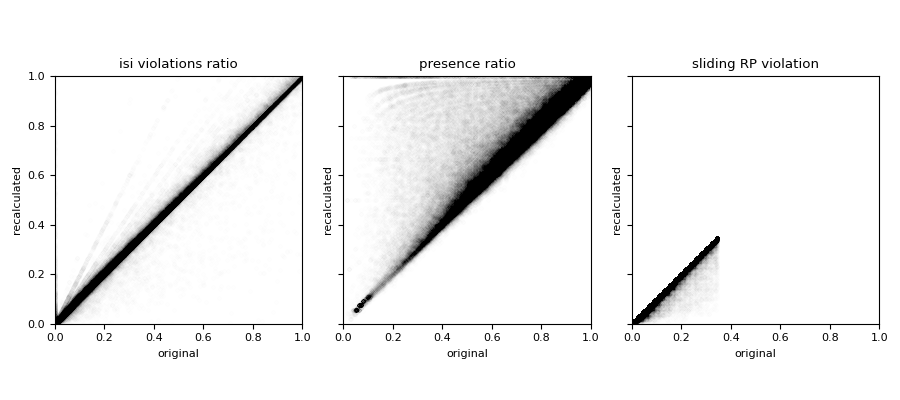

In [118]:
#compare already calculated metrics to recalculated - sanity check

fig,ax=plt.subplots(1,3,figsize=(9,4),sharex=True,sharey=True)
#isi_violations_ratio
ax[0].plot(all_units_new_metrics['isi_violations_ratio'],
           all_units_new_metrics['isi_violations_ratio_normal'],
           'k.',alpha=0.005)
ax[0].set_xlabel('original')
ax[0].set_ylabel('recalculated')
ax[0].set_title('isi violations ratio')
# ax[0].plot([0,1],[0,1],color='k')
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].set_aspect('equal')
#presence_ratio
ax[1].plot(all_units_new_metrics['presence_ratio'],
           all_units_new_metrics['presence_ratio_normal'],
           'k.',alpha=0.005)
ax[1].set_xlabel('original')
ax[1].set_ylabel('recalculated')
ax[1].set_title('presence ratio')
# ax[1].plot([0,1],[0,1],color='k')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].set_aspect('equal')
#sliding_rp
ax[2].plot(all_units_new_metrics['sliding_rp_violation'],
           all_units_new_metrics['sliding_rp_violation_normal'],
           'k.',alpha=0.005)
ax[2].set_xlabel('original')
ax[2].set_ylabel('recalculated')
ax[2].set_title('sliding RP violation')
# ax[2].plot([0,1],[0,1],color='k')
ax[2].set_xlim([0,1])
ax[2].set_ylim([0,1])
ax[2].set_aspect('equal')
plt.tight_layout()
plt.show()


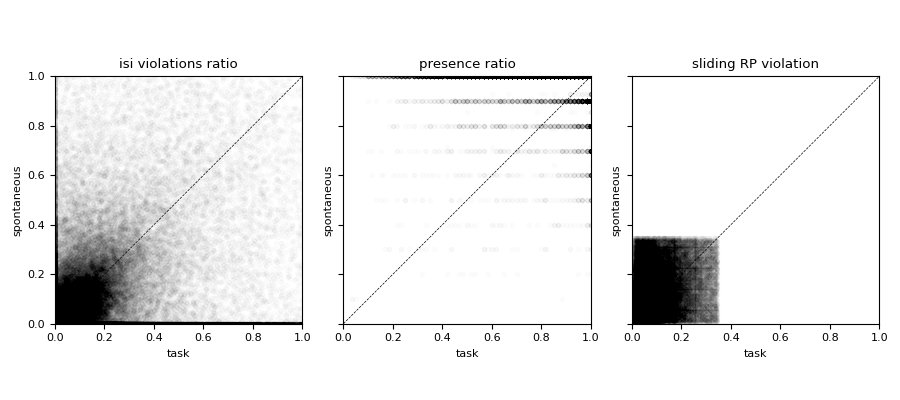

In [120]:
#compare task and spontaneous

fig,ax=plt.subplots(1,3,figsize=(9,4),sharex=True,sharey=True)
#isi_violations_ratio
ax[0].plot(all_units_new_metrics['isi_violations_ratio_task'],
           all_units_new_metrics['isi_violations_ratio_spont'],
           'k.',alpha=0.01)
ax[0].set_xlabel('task')
ax[0].set_ylabel('spontaneous')
ax[0].set_title('isi violations ratio')
ax[0].plot([0,1],[0,1],color='k',linestyle='--',linewidth=0.5)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].set_aspect('equal')
#presence_ratio
ax[1].plot(all_units_new_metrics['presence_ratio_task'],
           all_units_new_metrics['presence_ratio_spont'],
           'k.',alpha=0.01)
ax[1].set_xlabel('task')
ax[1].set_ylabel('spontaneous')
ax[1].set_title('presence ratio')
ax[1].plot([0,1],[0,1],color='k',linestyle='--',linewidth=0.5)
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].set_aspect('equal')
#sliding_rp
ax[2].plot(all_units_new_metrics['sliding_rp_violation_task'],
           all_units_new_metrics['sliding_rp_violation_spont'],
           'k.',alpha=0.01)
ax[2].set_xlabel('task')
ax[2].set_ylabel('spontaneous')
ax[2].set_title('sliding RP violation')
ax[2].plot([0,1],[0,1],color='k',linestyle='--',linewidth=0.5)
ax[2].set_xlim([0,1])
ax[2].set_ylim([0,1])
ax[2].set_aspect('equal')
plt.tight_layout()
plt.show()


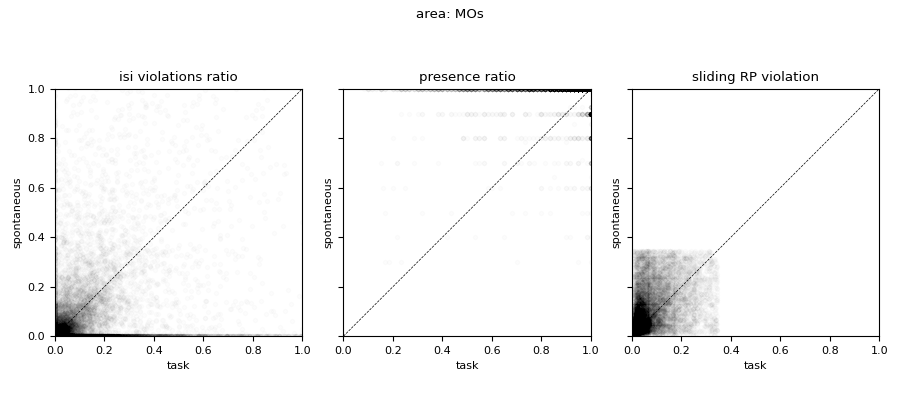

In [ ]:
sel_area='MOs'

area_units=all_units_new_metrics.query('structure==@sel_area')

#compare task and spontaneous

fig,ax=plt.subplots(1,3,figsize=(9,4),sharex=True,sharey=True)
#isi_violations_ratio
ax[0].plot(area_units['isi_violations_ratio_task'],
           area_units['isi_violations_ratio_spont'],
           'k.',alpha=0.01)
ax[0].set_xlabel('task')
ax[0].set_ylabel('spontaneous')
ax[0].set_title('isi violations ratio')
ax[0].plot([0,1],[0,1],color='k',linestyle='--',linewidth=0.5)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].set_aspect('equal')
#presence_ratio
ax[1].plot(area_units['presence_ratio_task'],
           area_units['presence_ratio_spont'],
           'k.',alpha=0.01)
ax[1].set_xlabel('task')
ax[1].set_ylabel('spontaneous')
ax[1].set_title('presence ratio')
ax[1].plot([0,1],[0,1],color='k',linestyle='--',linewidth=0.5)
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].set_aspect('equal')
#sliding_rp
ax[2].plot(area_units['sliding_rp_violation_task'],
           area_units['sliding_rp_violation_spont'],
           'k.',alpha=0.01)
ax[2].set_xlabel('task')
ax[2].set_ylabel('spontaneous')
ax[2].set_title('sliding RP violation')
ax[2].plot([0,1],[0,1],color='k',linestyle='--',linewidth=0.5)
ax[2].set_xlim([0,1])
ax[2].set_ylim([0,1])
ax[2].set_aspect('equal')

fig.suptitle('area: '+sel_area)
fig.tight_layout()



In [123]:
unique_areas=all_units_new_metrics['structure'].unique()
unique_areas

array(['ACAd', 'ACAv', 'CA1', 'CA3', 'DG', 'IG', 'LSr', 'MOs', 'TEa',
       'VISl', 'VISli', 'VISp', 'out of brain', 'AD', 'AUDd', 'DP', 'ILA',
       'MB', 'MOp', 'NB', 'OLF', 'ORBm', 'PL', 'POST', 'RSPagl', 'RSPd',
       'RSPv', 'SSs', 'TTd', 'VISal', 'VL', 'CP', 'FRP', 'HPF', 'ORBl',
       'ORBvl', 'SSp', 'SUB', 'root', 'AUDp', 'AUDpo', 'IGL', 'IntG',
       'LD', 'LGd', 'LGv', 'LP', 'PO', 'STR', 'TH', 'VISpm', 'VPM', 'ZI',
       'or', 'ICe', 'ProS', 'SCig', 'PoT', 'SGN', 'VISam', 'CA2', 'MRN',
       'SEZ', 'MGd', 'MGv', 'BST', 'Eth', 'fa', 'VISa', 'VISrl', 'ACB',
       'AId', 'AIv', 'PAL', 'PIR', 'LSv', 'alv', 'LA', 'V3', 'bsc', 'APN',
       'POL', 'RT', 'AV', 'ccb', 'scwm', 'ccg', 'CUN', 'ICd', 'LSc',
       'MGm', 'PPN', 'PRE', 'DT', 'SAG', 'SCiw', 'SCop', 'SCsg', 'VISpor',
       'VPL', 'fp', 'TRS', 'SCzo', 'undefined', 'SCdg', 'int', 'GPe',
       'RN', 'PIL', 'SNr', 'PP', 'MS', 'VAL', None, 'HY', 'PAG', 'SCdw',
       'VM', 'cing', 'EPd', 'GPi', 'MEA', 'OT', 'SI', 'fibe

In [ ]:
# include areas with recordings in at least 3 sessions, and at least 20 units in each session, and no lowercase or general areas.

unique_areas=all_units_new_metrics['structure'].unique()
included_areas=[]

for aa in unique_areas:
    if aa==None:
        print('excluded due to None')
        continue
    if aa[0].islower():
        print(aa+' excluded due to lowercase')
        continue
    unique_sessions=all_units_new_metrics.query('structure==@aa')['session_id'].unique()
    n_unique_sessions=len(unique_sessions)
    if n_unique_sessions<3:
        print(aa+' excluded due to too few sessions')
        continue
    n_units_per_session=all_units_new_metrics.query('structure==@aa').groupby('session_id').count()['unit_id']
    n_sessions_with_enough_units=(n_units_per_session>=20).sum()
    if n_sessions_with_enough_units<3:
        print(aa+' excluded due to too few units per session')
        continue

    included_areas.append(aa)


out of brain excluded due to lowercase
AD excluded due to too few units per session
root excluded due to lowercase
IntG excluded due to too few units per session
or excluded due to lowercase
SEZ excluded due to too few units per session
fa excluded due to lowercase
alv excluded due to lowercase
V3 excluded due to too few units per session
bsc excluded due to lowercase
ccb excluded due to lowercase
scwm excluded due to lowercase
ccg excluded due to lowercase
CUN excluded due to too few sessions
ICd excluded due to too few sessions
PPN excluded due to too few sessions
DT excluded due to too few sessions
SAG excluded due to too few units per session
fp excluded due to lowercase
SCzo excluded due to too few units per session
undefined excluded due to lowercase
int excluded due to lowercase
PP excluded due to too few units per session
MS excluded due to too few units per session
excluded due to None
HY excluded due to too few units per session
SCdw excluded due to too few units per session


In [168]:
# plot fraction of units included across different areas using task vs. spont vs. normal metrics

metrics_by_area={
    'area':[],
    'isi_violations_ratio_normal':[],
    'isi_violations_ratio_task':[],
    'isi_violations_ratio_spont':[],
    'presence_ratio_normal':[],
    'presence_ratio_task':[],
    'presence_ratio_spont':[],
    'sliding_rp_violation_normal':[],
    'sliding_rp_violation_task':[],
    'sliding_rp_violation_spont':[],
}

isi_violations_thresh=0.1
presence_ratio_thresh=0.99
sliding_rp_thresh=0.1
frac_pass_by_area={
    'area':[],
    'isi_violations_ratio_normal':[],
    'isi_violations_ratio_task':[],
    'isi_violations_ratio_spont':[],
    'presence_ratio_normal':[],
    'presence_ratio_task':[],
    'presence_ratio_spont':[],
    'sliding_rp_violation_normal':[],
    'sliding_rp_violation_task':[],
    'sliding_rp_violation_spont':[],
}

for aa in included_areas:
    metrics_by_area['area'].append(aa)
    area_units=all_units_new_metrics.query('structure==@aa')
    metrics_by_area['isi_violations_ratio_normal'].append(np.nanmedian(area_units['isi_violations_ratio_normal']))
    metrics_by_area['isi_violations_ratio_task'].append(np.nanmedian(area_units['isi_violations_ratio_task']))
    metrics_by_area['isi_violations_ratio_spont'].append(np.nanmedian(area_units['isi_violations_ratio_spont']))
    metrics_by_area['presence_ratio_normal'].append(np.nanmean(area_units['presence_ratio_normal']))
    metrics_by_area['presence_ratio_task'].append(np.nanmean(area_units['presence_ratio_task']))
    metrics_by_area['presence_ratio_spont'].append(np.nanmean(area_units['presence_ratio_spont']))
    metrics_by_area['sliding_rp_violation_normal'].append(np.nanmedian(area_units['sliding_rp_violation_normal']))
    metrics_by_area['sliding_rp_violation_task'].append(np.nanmedian(area_units['sliding_rp_violation_task']))
    metrics_by_area['sliding_rp_violation_spont'].append(np.nanmedian(area_units['sliding_rp_violation_spont']))

    frac_pass_by_area['area'].append(aa)
    frac_pass_by_area['isi_violations_ratio_normal'].append((area_units.query('~isi_violations_ratio_normal.isna()')['isi_violations_ratio_normal']<=isi_violations_thresh).mean())
    frac_pass_by_area['isi_violations_ratio_task'].append((area_units.query('~isi_violations_ratio_task.isna()')['isi_violations_ratio_task']<=isi_violations_thresh).mean())
    frac_pass_by_area['isi_violations_ratio_spont'].append((area_units.query('~isi_violations_ratio_spont.isna()')['isi_violations_ratio_spont']<=isi_violations_thresh).mean())
    frac_pass_by_area['presence_ratio_normal'].append((area_units.query('~presence_ratio_normal.isna()')['presence_ratio_normal']>=presence_ratio_thresh).mean())
    frac_pass_by_area['presence_ratio_task'].append((area_units.query('~presence_ratio_task.isna()')['presence_ratio_task']>=presence_ratio_thresh).mean())
    frac_pass_by_area['presence_ratio_spont'].append((area_units.query('~presence_ratio_spont.isna()')['presence_ratio_spont']>=presence_ratio_thresh).mean())
    frac_pass_by_area['sliding_rp_violation_normal'].append((area_units.query('~sliding_rp_violation_normal.isna()')['sliding_rp_violation_normal']<=sliding_rp_thresh).mean())
    frac_pass_by_area['sliding_rp_violation_task'].append((area_units.query('~sliding_rp_violation_task.isna()')['sliding_rp_violation_task']<=sliding_rp_thresh).mean())
    frac_pass_by_area['sliding_rp_violation_spont'].append((area_units.query('~sliding_rp_violation_spont.isna()')['sliding_rp_violation_spont']<=sliding_rp_thresh).mean())

metrics_by_area_df=pd.DataFrame(metrics_by_area)

frac_pass_by_area_df=pd.DataFrame(frac_pass_by_area)


In [169]:
# all_units_new_metrics.query('presence_ratio_spont.isna()')

In [170]:
frac_pass_by_area_df

,area,isi_violations_ratio_normal,isi_violations_ratio_task,isi_violations_ratio_spont,presence_ratio_normal,presence_ratio_task,presence_ratio_spont,sliding_rp_violation_normal,sliding_rp_violation_task,sliding_rp_violation_spont
0,ACAd,0.724780,0.750109,0.839682,0.555763,0.647689,0.971255,0.652605,0.632051,0.622963
1,ACAv,0.719331,0.744060,0.806665,0.581413,0.669816,0.975507,0.630319,0.609558,0.584694
2,CA1,0.501980,0.525725,0.591484,0.603859,0.660269,0.979451,0.532969,0.539670,0.560281
3,CA3,0.495427,0.529075,0.597985,0.536707,0.602512,0.973552,0.559630,0.575071,0.616687
4,DG,0.501915,0.520971,0.562357,0.557005,0.602047,0.975261,0.589286,0.583533,0.595152
...,...,...,...,...,...,...,...,...,...,...
110,VPMpc,0.530000,0.591837,0.693182,0.900000,0.928571,1.000000,0.851852,0.769231,0.593220
111,FF,0.545082,0.590476,0.702857,0.635246,0.790476,0.960000,0.828025,0.870968,0.779661
112,VISpl,0.631356,0.696517,0.807947,0.525424,0.661692,0.973510,0.646154,0.678261,0.614458
113,AIp,0.555901,0.617544,0.656085,0.549689,0.705263,0.994709,0.565891,0.525862,0.508772


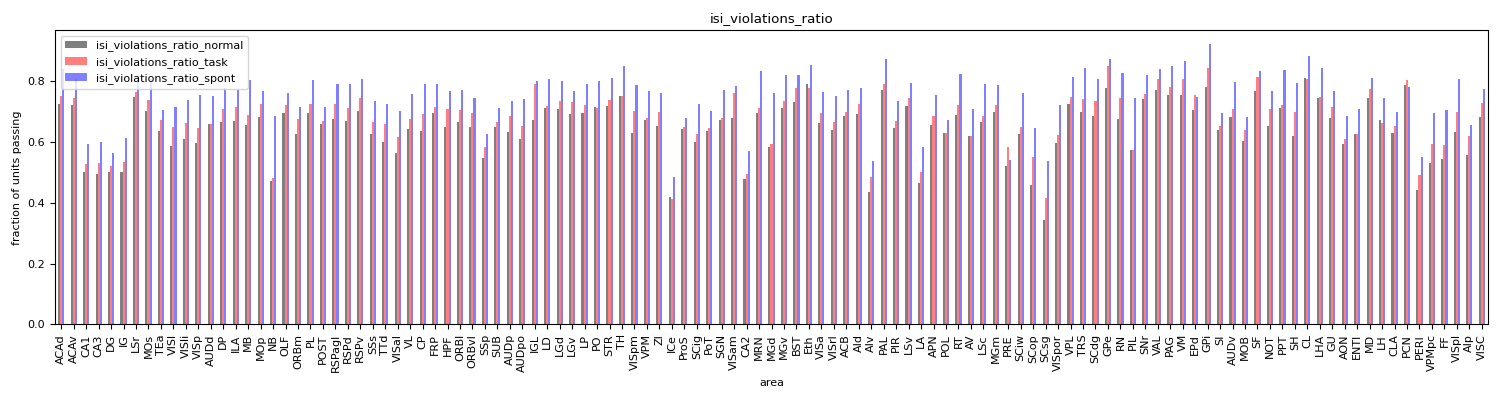

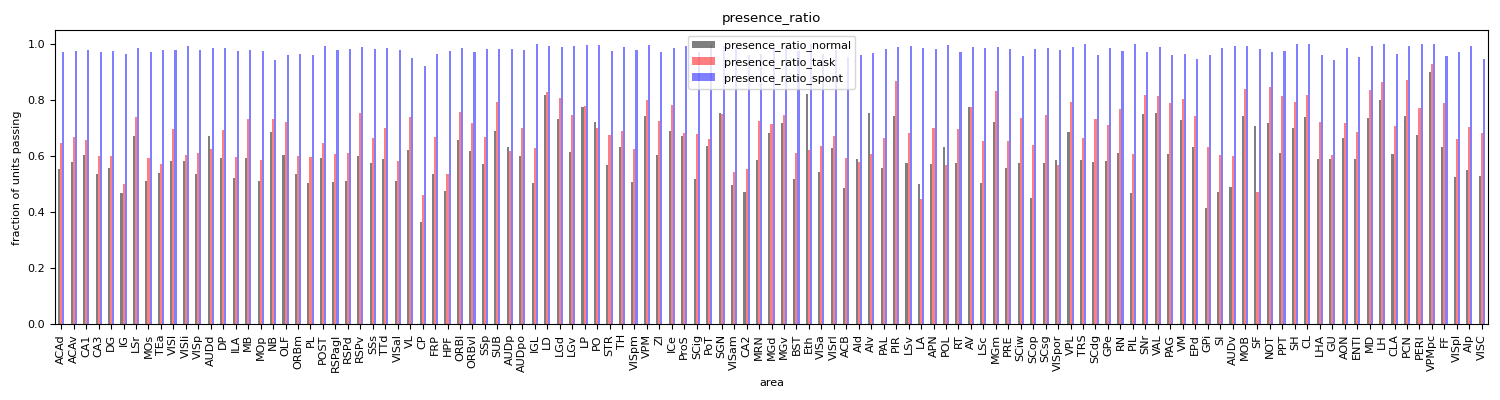

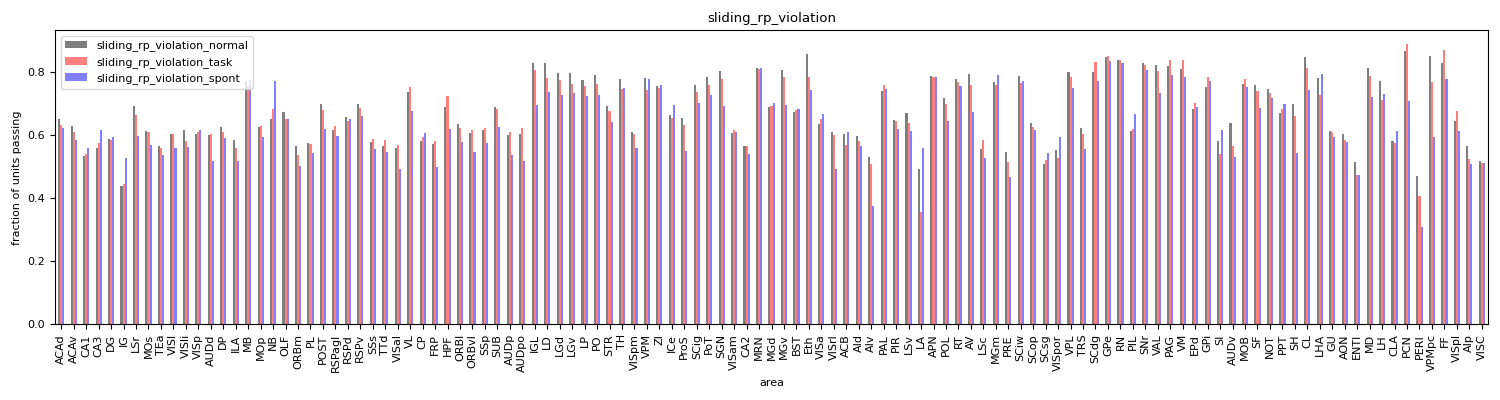

In [171]:
#plot fraction passing for each area in barplot

metrics=['isi_violations_ratio','presence_ratio','sliding_rp_violation']

for mm in metrics:
    fig,ax=plt.subplots(1,1,figsize=(15,4))

    frac_pass_by_area_df.plot.bar(ax=ax,x='area',y=[mm+'_normal',mm+'_task',mm+'_spont'],color=['k','r','b'],alpha=0.5)

    ax.set_ylabel('fraction of units passing')
    ax.set_title(mm)
    plt.legend()
    plt.tight_layout()
    plt.show()

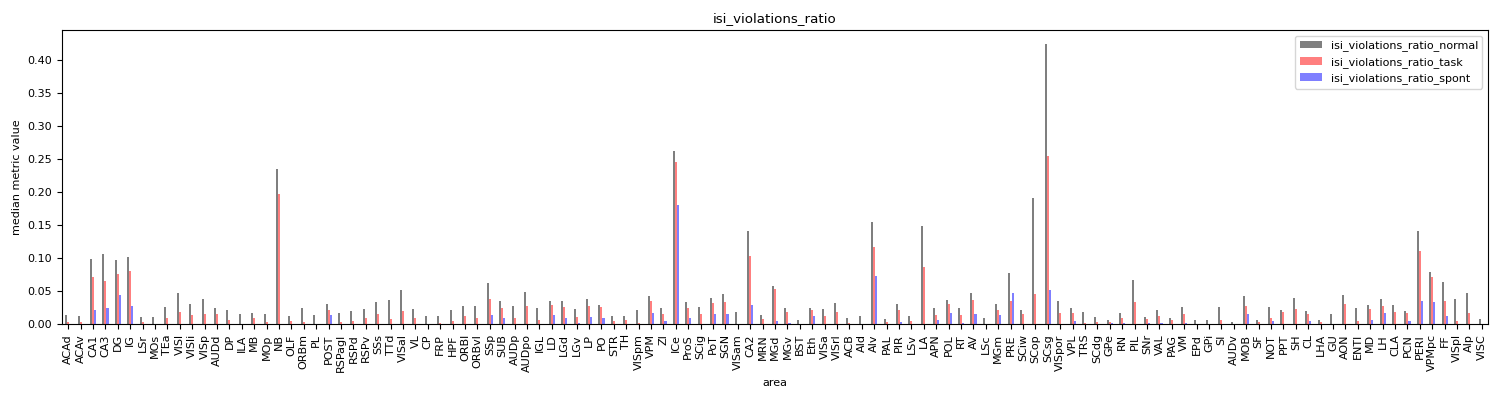

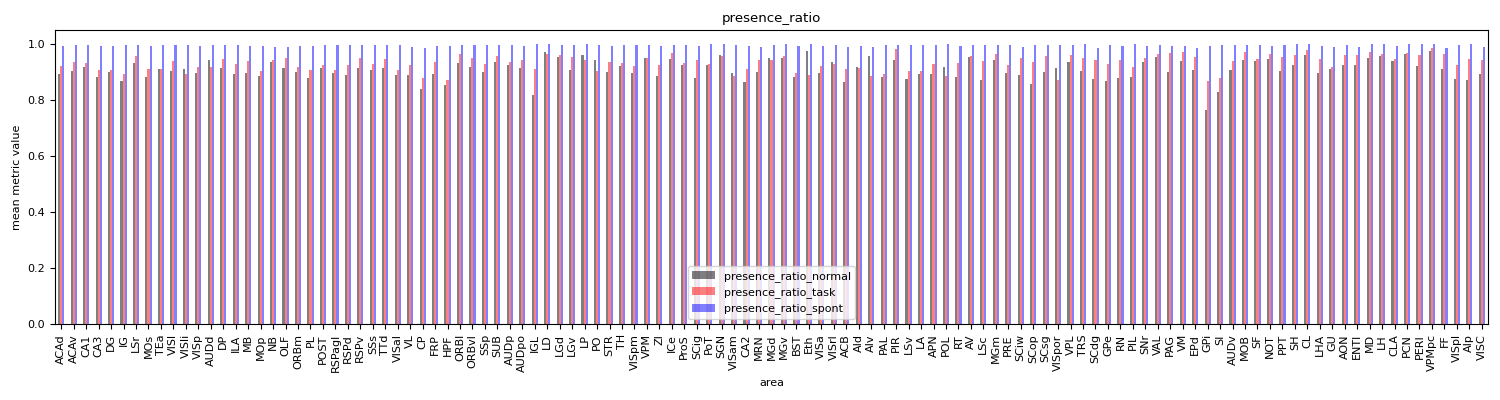

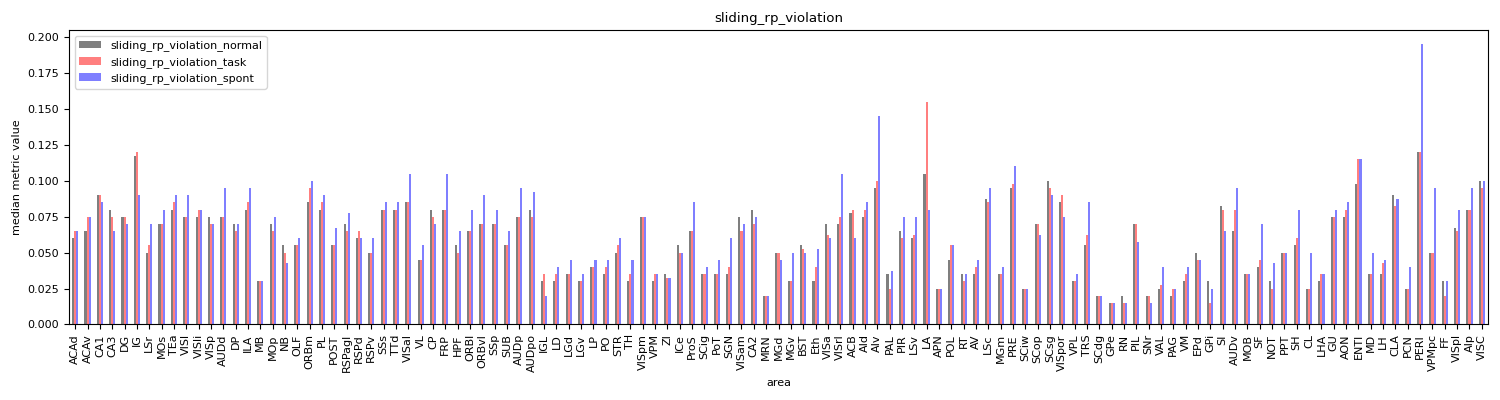

In [161]:
#plot average metrics for each area in barplot

metrics=['isi_violations_ratio','presence_ratio','sliding_rp_violation']

for mm in metrics:
    fig,ax=plt.subplots(1,1,figsize=(15,4))

    metrics_by_area_df.plot.bar(ax=ax,x='area',y=[mm+'_normal',mm+'_task',mm+'_spont'],color=['k','r','b'],alpha=0.5)
    if mm=='presence_ratio':
        ax.set_ylabel('mean metric value')
    else:
        ax.set_ylabel('median metric value')
    ax.set_title(mm)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [225]:
#for each session and area, ask if >10, >20, >30, >40 units pass each metric

metrics_by_session={
    'session_id':[],
    'area':[],
    'n_units_threshold':[],
    'isi_violations_ratio_normal':[],
    'isi_violations_ratio_task':[],
    'isi_violations_ratio_spont':[],
    'presence_ratio_normal':[],
    'presence_ratio_task':[],
    'presence_ratio_spont':[],
    'sliding_rp_violation_normal':[],
    'sliding_rp_violation_task':[],
    'sliding_rp_violation_spont':[],
}

isi_violations_thresh=0.1
presence_ratio_thresh=0.99
sliding_rp_thresh=0.1

for ss in ephys_sessions:
    for aa in included_areas:
        area_units=all_units_new_metrics.query('structure==@aa and session_id==@ss')
        for thresh in [10,20,30,40]:
            metrics_by_session['session_id'].append(ss)
            metrics_by_session['area'].append(aa)
            metrics_by_session['n_units_threshold'].append(thresh)
            metrics_by_session['isi_violations_ratio_normal'].append((area_units['isi_violations_ratio_normal']<=isi_violations_thresh).sum()>=thresh)
            metrics_by_session['isi_violations_ratio_task'].append((area_units['isi_violations_ratio_task']<=isi_violations_thresh).sum()>=thresh)
            metrics_by_session['isi_violations_ratio_spont'].append((area_units['isi_violations_ratio_spont']<=isi_violations_thresh).sum()>=thresh)
            metrics_by_session['presence_ratio_normal'].append((area_units['presence_ratio_normal']>=presence_ratio_thresh).sum()>=thresh)
            metrics_by_session['presence_ratio_task'].append((area_units['presence_ratio_task']>=presence_ratio_thresh).sum()>=thresh)
            metrics_by_session['presence_ratio_spont'].append((area_units['presence_ratio_spont']>=presence_ratio_thresh).sum()>=thresh)
            metrics_by_session['sliding_rp_violation_normal'].append((area_units['sliding_rp_violation_normal']<=sliding_rp_thresh).sum()>=thresh)
            metrics_by_session['sliding_rp_violation_task'].append((area_units['sliding_rp_violation_task']<=sliding_rp_thresh).sum()>=thresh)
            metrics_by_session['sliding_rp_violation_spont'].append((area_units['sliding_rp_violation_spont']<=sliding_rp_thresh).sum()>=thresh)

metrics_by_session_df=pd.DataFrame(metrics_by_session)

In [224]:
# presence_ratio_thresh=0.9
# thresh=10
# aa='MOs'
# area_units=all_units_new_metrics.query('structure==@aa and session_id==@ss')
# (area_units['presence_ratio_task']>=presence_ratio_thresh).sum()


20

In [233]:
metrics_by_session_df

,session_id,area,n_units_threshold,isi_violations_ratio_normal,isi_violations_ratio_task,isi_violations_ratio_spont,presence_ratio_normal,presence_ratio_task,presence_ratio_spont,sliding_rp_violation_normal,sliding_rp_violation_task,sliding_rp_violation_spont
0,620263_2022-07-26_0,ACAd,10,True,True,False,True,True,False,True,True,False
1,620263_2022-07-26_0,ACAd,20,True,True,False,True,True,False,True,True,False
2,620263_2022-07-26_0,ACAd,30,True,True,False,True,True,False,True,True,False
3,620263_2022-07-26_0,ACAd,40,True,True,False,True,True,False,True,True,False
4,620263_2022-07-26_0,ACAv,10,True,True,False,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
83715,761584_2024-10-30_0,AIp,40,False,False,False,False,False,False,False,False,False
83716,761584_2024-10-30_0,VISC,10,False,False,False,False,False,False,False,False,False
83717,761584_2024-10-30_0,VISC,20,False,False,False,False,False,False,False,False,False
83718,761584_2024-10-30_0,VISC,30,False,False,False,False,False,False,False,False,False


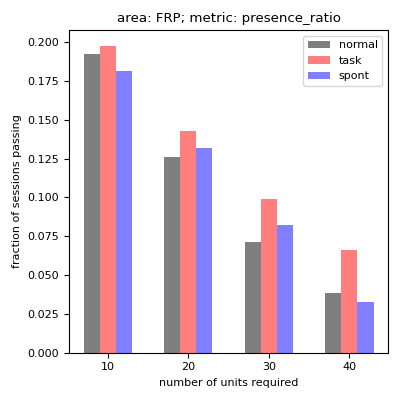

In [232]:
aa='FRP'
metric='presence_ratio'
# metric='isi_violations_ratio'
# metric='sliding_rp_violation'


normal_metric=metric+'_normal'
task_metric=metric+'_task'
spont_metric=metric+'_spont'

normal_10_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==10')[metric+'_normal'].mean()
# normal_10_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==10')[metric+'_normal'].sem()
normal_20_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==20')[metric+'_normal'].mean()
# normal_20_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==20')[metric+'_normal'].sem()
normal_30_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==30')[metric+'_normal'].mean()
# normal_30_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==30')[metric+'_normal'].sem()
normal_40_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==40')[metric+'_normal'].mean()
# normal_40_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==40')[metric+'_normal'].sem()

task_10_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==10')[metric+'_task'].mean()
# task_10_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==10')[metric+'_task'].sem()
task_20_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==20')[metric+'_task'].mean()
# task_20_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==20')[metric+'_task'].sem()
task_30_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==30')[metric+'_task'].mean()
# task_30_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==30')[metric+'_task'].sem()
task_40_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==40')[metric+'_task'].mean()
# task_40_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==40')[metric+'_task'].sem()

spont_10_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==10')[metric+'_spont'].mean()
# spont_10_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==10')[metric+'_spont'].sem()
spont_20_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==20')[metric+'_spont'].mean()
# spont_20_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==20')[metric+'_spont'].sem()
spont_30_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==30')[metric+'_spont'].mean()
# spont_30_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==30')[metric+'_spont'].sem()
spont_40_mean=metrics_by_session_df.query('area==@aa and n_units_threshold==40')[metric+'_spont'].mean()
# spont_40_sem=metrics_by_session_df.query('area==@aa and n_units_threshold==40')[metric+'_spont'].sem()

y_values_normal=[normal_10_mean,normal_20_mean,normal_30_mean,normal_40_mean]
# yerr_normal=[normal_10_sem,normal_20_sem,normal_30_sem,normal_40_sem]

y_values_task=[task_10_mean,task_20_mean,task_30_mean,task_40_mean]
# yerr_task=[task_10_sem,task_20_sem,task_30_sem,task_40_sem]

y_values_spont=[spont_10_mean,spont_20_mean,spont_30_mean,spont_40_mean]
# yerr_spont=[spont_10_sem,spont_20_sem,spont_30_sem,spont_40_sem]

x_values=np.arange(4)
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.bar(x_values-0.2,y_values_normal,color='k',label='normal',alpha=0.5,width=0.2)
ax.bar(x_values,y_values_task,color='r',label='task',alpha=0.5,width=0.2)
ax.bar(x_values+0.2,y_values_spont,color='b',label='spont',alpha=0.5,width=0.2)
ax.set_xticks(x_values)
ax.set_xticklabels([10,20,30,40])
ax.set_ylabel('fraction of sessions passing')
ax.set_xlabel('number of units required')
ax.legend()
ax.set_title('area: '+aa+'; metric: '+metric)

fig.tight_layout()





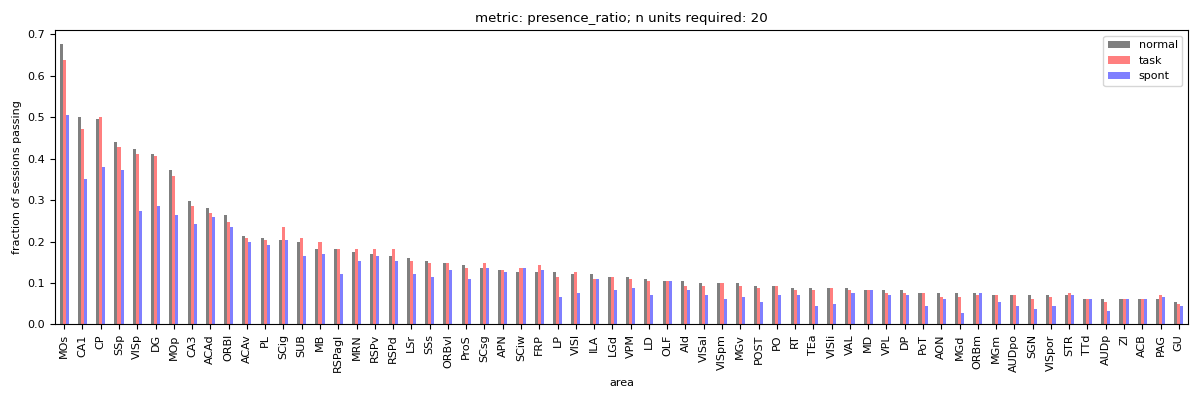

In [240]:
#plot across areas, fix number of units

n_units=20
metric='presence_ratio'
# metric='isi_violations_ratio'
# metric='sliding_rp_violation'

normal_metric=metric+'_normal'
task_metric=metric+'_task'
spont_metric=metric+'_spont'

n_units_df=metrics_by_session_df.query('n_units_threshold==@n_units')
# n_units_df

unique_areas=n_units_df['area'].unique()

frac_session_passing={
    'area':[],
    'normal':[],
    'task':[],
    'spont':[],
    'metric':[],
}

for aa in unique_areas:
    frac_session_passing['area'].append(aa)
    frac_session_passing['normal'].append(n_units_df.query('area==@aa')[normal_metric].mean())
    frac_session_passing['task'].append(n_units_df.query('area==@aa')[task_metric].mean())
    frac_session_passing['spont'].append(n_units_df.query('area==@aa')[spont_metric].mean())
    frac_session_passing['metric'].append(metric)

frac_session_passing_df=pd.DataFrame(frac_session_passing)
frac_session_passing_df.sort_values(by='normal',inplace=True,ascending=False)
frac_session_passing_df=frac_session_passing_df.query('normal>0.05')

fig,ax=plt.subplots(1,1,figsize=(12,4))

frac_session_passing_df.plot.bar(ax=ax,x='area',y=['normal','task','spont'],color=['k','r','b'],alpha=0.5)
ax.set_ylabel('fraction of sessions passing')
ax.set_xlabel('area')
ax.set_title('metric: '+metric+'; n units required: '+str(n_units))
fig.tight_layout()

In [ ]:
#plot across areas, fix time window